In [3]:

import xarray as xr


ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')

import pandas as pd
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
df_obl = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\obl.csv")

df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

ds_sat.info()

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
		age:long_name = reconstruction bin mid-point (years BP) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [9]:
ds_sat

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



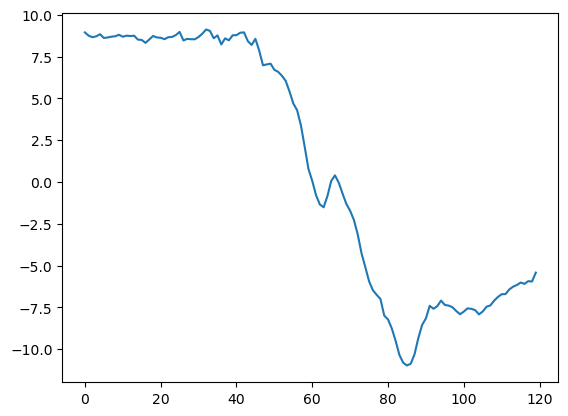

In [10]:
# plot any sat from the ds_sat

import matplotlib.pyplot as plt
import numpy as np

plt.plot(ds_sat['sat'].isel(lat=80).isel(lon=0).values)

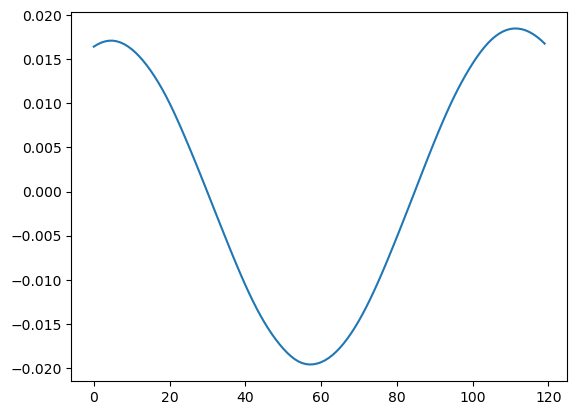

In [12]:
# plot df_pre
plt.plot(df_pre['pre'].values)

# print(df_pre['pre'].values)

In [14]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


# assert ds_sat.sizes["age"] == len(df_pre), (
#     "ds_sat age dimension must match length of precession time series."
# )


# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # not strictly needed but good to keep track

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)



results_list = []  # will be a list of (ilat, ilon, Evals, Tauvals, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    # Accessed as RhoMatrix[E-1, tau-1].
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=7,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
            # If you want to speed up or parallelize, you can set numThreads or numProcess
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            # print(e_val)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # We'll store the axis values for plotting (note: we want these in 2D for a surface plot).
    E_axis = np.arange(1, 6)     # 1..5
    Tau_axis = np.arange(1, 11)  # 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results
#    using Plotly subplots
# ---------------------------------------------------------------------

# We'll do 2 rows, 5 columns of 3D subplots
fig = make_subplots(
    rows=2, cols=5,
    specs=[
        [{"type": "surface"}]*5,
        [{"type": "surface"}]*5
    ],
    subplot_titles=[f"Point {i+1}: (lat={r[0]}, lon={r[1]})" for i, r in enumerate(results_list)]
)

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):

    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')

    row = (i // 5) + 1
    col = (i % 5) + 1

    # Create the surface trace
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho
        colorscale="Viridis",   # or any Plotly colormap you like
        showscale=False         # hide colorbar in subplots for neatness
    )
    fig.add_trace(surf, row=row, col=col)

# Update overall layout
fig.update_layout(
    height=800, width=1400,
    title="EmbedDimension scan of E in [1..5], tau in [1..10] (Tp = tau)",
    scene=dict(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho"
    ),
    # If you prefer separate axis labels per subplot, you can set them individually
    # with fig.update_xaxes(..., row=?, col=?)
)

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el

In [15]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


# assert ds_sat.sizes["age"] == len(df_pre), (
#     "ds_sat age dimension must match length of precession time series."
# )


# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # not strictly needed but good to keep track

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)



results_list = []  # will be a list of (ilat, ilon, Evals, Tauvals, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    # Accessed as RhoMatrix[E-1, tau-1].
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=0,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
            # If you want to speed up or parallelize, you can set numThreads or numProcess
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            # print(e_val)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # We'll store the axis values for plotting (note: we want these in 2D for a surface plot).
    E_axis = np.arange(1, 6)     # 1..5
    Tau_axis = np.arange(1, 11)  # 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results
#    using Plotly subplots
# ---------------------------------------------------------------------

# We'll do 2 rows, 5 columns of 3D subplots
fig = make_subplots(
    rows=2, cols=5,
    specs=[
        [{"type": "surface"}]*5,
        [{"type": "surface"}]*5
    ],
    subplot_titles=[f"Point {i+1}: (lat={r[0]}, lon={r[1]})" for i, r in enumerate(results_list)]
)

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):

    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')

    row = (i // 5) + 1
    col = (i % 5) + 1

    # Create the surface trace
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho
        colorscale="Viridis",   # or any Plotly colormap you like
        showscale=False         # hide colorbar in subplots for neatness
    )
    fig.add_trace(surf, row=row, col=col)

# Update overall layout
fig.update_layout(
    height=800, width=1400,
    title="EmbedDimension scan of E in [1..5], tau in [1..10] (Tp = tau)",
    scene=dict(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho"
    ),
    # If you prefer separate axis labels per subplot, you can set them individually
    # with fig.update_xaxes(..., row=?, col=?)
)

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el

In [16]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


# assert ds_sat.sizes["age"] == len(df_pre), (
#     "ds_sat age dimension must match length of precession time series."
# )


# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # not strictly needed but good to keep track

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)



results_list = []  # will be a list of (ilat, ilon, Evals, Tauvals, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    # Accessed as RhoMatrix[E-1, tau-1].
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=3,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
            # If you want to speed up or parallelize, you can set numThreads or numProcess
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            # print(e_val)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # We'll store the axis values for plotting (note: we want these in 2D for a surface plot).
    E_axis = np.arange(1, 6)     # 1..5
    Tau_axis = np.arange(1, 11)  # 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results
#    using Plotly subplots
# ---------------------------------------------------------------------

# We'll do 2 rows, 5 columns of 3D subplots
fig = make_subplots(
    rows=2, cols=5,
    specs=[
        [{"type": "surface"}]*5,
        [{"type": "surface"}]*5
    ],
    subplot_titles=[f"Point {i+1}: (lat={r[0]}, lon={r[1]})" for i, r in enumerate(results_list)]
)

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):

    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')

    row = (i // 5) + 1
    col = (i % 5) + 1

    # Create the surface trace
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho
        colorscale="Viridis",   # or any Plotly colormap you like
        showscale=False         # hide colorbar in subplots for neatness
    )
    fig.add_trace(surf, row=row, col=col)

# Update overall layout
fig.update_layout(
    height=800, width=1400,
    title="EmbedDimension scan of E in [1..5], tau in [1..10] (Tp = tau)",
    scene=dict(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho"
    ),
    # If you prefer separate axis labels per subplot, you can set them individually
    # with fig.update_xaxes(..., row=?, col=?)
)

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el

In [18]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


# assert ds_sat.sizes["age"] == len(df_pre), (
#     "ds_sat age dimension must match length of precession time series."
# )


# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # not strictly needed but good to keep track

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)



results_list = []  # will be a list of (ilat, ilon, Evals, Tauvals, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    # Accessed as RhoMatrix[E-1, tau-1].
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=30,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
            # If you want to speed up or parallelize, you can set numThreads or numProcess
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            # print(e_val)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # We'll store the axis values for plotting (note: we want these in 2D for a surface plot).
    E_axis = np.arange(1, 6)     # 1..5
    Tau_axis = np.arange(1, 11)  # 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results
#    using Plotly subplots
# ---------------------------------------------------------------------

# We'll do 2 rows, 5 columns of 3D subplots
fig = make_subplots(
    rows=2, cols=5,
    specs=[
        [{"type": "surface"}]*5,
        [{"type": "surface"}]*5
    ],
    subplot_titles=[f"Point {i+1}: (lat={r[0]}, lon={r[1]})" for i, r in enumerate(results_list)]
)

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):

    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')

    row = (i // 5) + 1
    col = (i % 5) + 1

    # Create the surface trace
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho
        colorscale="Viridis",   # or any Plotly colormap you like
        showscale=False         # hide colorbar in subplots for neatness
    )
    fig.add_trace(surf, row=row, col=col)

# Update overall layout
fig.update_layout(
    height=800, width=1400,
    title="EmbedDimension scan of E in [1..5], tau in [1..10] (Tp = tau)",
    scene=dict(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho"
    ),
    # If you prefer separate axis labels per subplot, you can set them individually
    # with fig.update_xaxes(..., row=?, col=?)
)

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el

In [1]:
import pandas as pd
import numpy as np



import pyEDM
import matplotlib.pyplot as plt

def find_best_E(df, E_values, data_column='d18O', 
                lib=None, pred=None, tau=-1, Tp=1, noTime=False):
    """
    df          : DataFrame with columns [Time, data_column]
    E_values    : iterable of embedding dimensions to test
    data_column : name of the column to forecast
    lib         : string specifying the library rows, e.g. '1 900'
    pred        : string specifying the prediction rows, e.g. '901 1851'
    tau         : embedding time-lag (default -1 = let pyEDM guess or use default)
    Tp          : prediction horizon (default 1)
    noTime      : if True, pyEDM will assume there's no separate time column
    """
    N = len(df)
    if lib is None or pred is None:
        # Example: first half for library, second half for prediction
        mid = N // 2
        lib  = f"1 {mid}"
        pred = f"{mid+1} {N}"
    
    results = {}
    for E in E_values:
        # Run Simplex
        simplex_out = pyEDM.Simplex(
            dataFrame = df,
            columns   = data_column,  # library columns
            target    = data_column,  # predict the same variable
            lib       = lib,
            pred      = pred,
            E         = E,
            Tp        = Tp,
            tau       = tau,
            knn       = 0,        # 0 => use E+1 neighbors
            embedded  = False,    # let pyEDM embed for us
            noTime    = noTime,   # if the first column is Time, set noTime=False
            showPlot  = False
        )
        
        # simplex_out is a DataFrame with columns ["Time","Observations","Predictions"]
        obs = simplex_out["Observations"].values
        pred_ = simplex_out["Predictions"].values
        
        # Compute correlation, ignoring NaNs
        valid_idx = ~np.isnan(obs) & ~np.isnan(pred_)
        if np.sum(valid_idx) > 1:
            rho_val = np.corrcoef(obs[valid_idx], pred_[valid_idx])[0,1]
        else:
            rho_val = np.nan
        
        results[E] = rho_val
    
    return results


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tau_values   = range(1, 10, 1)  # 10,20,30,...,100
E_candidates = range(1, 5)        # 1..8

# 2) We'll store results in 2D arrays:
#    rows = different tau, cols = different E
ant_results_3d   = np.zeros((len(tau_values), len(E_candidates)))
ngrip_results_3d = np.zeros((len(tau_values), len(E_candidates)))

# 3) Loop over all tau and E values to fill in the 2D arrays
for i, tau in enumerate(tau_values):
    ant_results = find_best_E(
        df, 
        E_values = E_candidates, 
        data_column = 'd18O',
        tau = tau,
        Tp = tau,           # forecast tau steps ahead
        lib='1 60',        # e.g. rows 1..900 as library
        pred='61 121',    # rows 901..1851 as prediction
        noTime=False
    )

    
    for j, E in enumerate(E_candidates):
        ant_results_3d[i,j]   = ant_results[E]
        ngrip_results_3d[i,j] = ngrip_results[E]

# e.g. to create mesh for x=E, y=tau:
E_grid, Tau_grid = np.meshgrid(E_candidates, tau_values)  # each shape: (len(tau_values), len(E_candidates))


# Create a 1x2 grid of 3D subplots
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Antarctic", "NGRIP"]
)

# -- Add the Antarctic surface (left subplot, row=1,col=1)
fig.add_trace(
    go.Surface(
        x=E_grid,          # embedding dimension
        y=Tau_grid,        # tau
        z=ant_results_3d,  # correlation skill
        colorscale='Viridis',
        name='Antarctic'
    ),
    row=1, col=1
)

# -- Add the NGRIP surface (right subplot, row=1,col=2)
fig.add_trace(
    go.Surface(
        x=E_grid,
        y=Tau_grid,
        z=ngrip_results_3d,
        colorscale='Viridis',
        name='NGRIP'
    ),
    row=1, col=2
)

# Update layout for each subplot’s axes and overall figure
fig.update_layout(
    title="Forecast Skill vs. E and tau (Tp = tau)",
    width=1200, height=600
)

# Customize the axis titles on each 3D subplot
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene1 settings
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene2 settings
    row=1, col=2
)

fig.show()
